# Réseau neuronal convolutif

## Imports

In [1]:
import numpy as np 
import shutil # pour les dossiers
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

## Chargement des images

In [2]:
def getContenu(path):
    files = os.listdir(path);
    contenu = [];
    for file in files:
        if file.endswith('.json'):
            openFile = open(path+file, "r");
            contenu.append(json.loads(openFile.read())["Image"]);
            openFile.close();
    return contenu;

In [3]:
chemin = "./train/";
contenu = [];
if not os.path.isdir(chemin):
    print('Rajouter le dossier train dans le dossier courant :) ! ');
else :
    contenu = getContenu(chemin);
    df = pd.DataFrame(contenu)
    # on laisse Species car c'est égale au nombre de classe
    df.drop(["Genus","ClassId","Family","Vote","Location","Latitude","Longitude","Date","Author","Content","MediaId", "LearnTag", "ImageId2014","ObservationId2014","YearInCLEF","ObservationId"], axis='columns', inplace=True)
    df = df.drop_duplicates()
    classe  = df.to_numpy();
    print(len(classe))


50


## On récupère le nom des png ainsi que leur classe

In [4]:
X = [];
Y = [];
files = os.listdir("./train")
for file in files:
    if file.endswith('.jpg'):
        X.append(file);
        nameFile = file.split('.')[0];
        for file_class in files:
            nameFileAutre = file_class.split('.')[0];
            if nameFile==nameFileAutre and file_class.endswith('.json'):
                fichierSrc = open("./train/"+file_class, "r");
                contenu = fichierSrc.read();
                monJson = json.loads(contenu)
                Y.append(monJson["Image"]["Species"])
                break;


In [5]:
# on a bien une classe par image !
if(len(X) == len(Y)):
    print("OK")
else:
    print("KO")

OK


In [6]:
# 60% train 20% test 20% val 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

## Mise en place de l'architecture dossier pour avoir les image_datasets

In [7]:
# Création des répertoires ! 
if(not os.path.isdir('./CNN/train')):
    os.mkdir('./CNN/train')
    
if(not os.path.isdir('./CNN/val')):
    os.mkdir('./CNN/val')
    
for classe in y_train : 
    if(not os.path.isdir('./CNN/train/'+classe)):
        os.mkdir('./CNN/train/'+classe)
        
for classe in y_val : 
    if(not os.path.isdir('./CNN/val/'+classe)):
        os.mkdir('./CNN/val/'+classe)
        
        
# on met les images dans les répertoires precédents

# on supprime le contenu

directorys=os.listdir('./CNN/train/')
for i in range(0,len(directorys)):
    files=os.listdir('./CNN/train/'+directorys[i])
    for j in range(0,len(files)):
        os.remove('./CNN/train/'+directorys[i]+'/'+files[j])

directorys=os.listdir('./CNN/val/')
for i in range(0,len(directorys)):
    files=os.listdir('./CNN/val/'+directorys[i])
    for j in range(0,len(files)):
        os.remove('./CNN/val/'+directorys[i]+'/'+files[j])
# on met le contenu

for i in range(len(X_train)):
    shutil.copyfile('./train/'+X_train[i],'./CNN/train/'+y_train[i]+'/'+X_train[i])
    
for i in range(len(X_val)):
    shutil.copyfile('./train/'+X_val[i],'./CNN/val/'+y_val[i]+'/'+X_val[i])
    

## Mise en place du CNN

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'CNN'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    evolution_accuracy = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
             
            if phase == 'val':
                evolution_accuracy.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print("Evolution de l'accuracy pour savoir si on doit augmenter l'époch : ")
    plt.plot(evolution_accuracy)
    plt.ylabel('Evolution accuracy par epoch')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
class_names = image_datasets['train'].classes
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



Epoch 0/19
----------
train Loss: 2.7953 Acc: 0.2764
val Loss: 1.2442 Acc: 0.6504

Epoch 1/19
----------
train Loss: 1.5831 Acc: 0.5504
val Loss: 0.7270 Acc: 0.7727

Epoch 2/19
----------
train Loss: 1.2355 Acc: 0.6550
val Loss: 0.6944 Acc: 0.7928

Epoch 3/19
----------
train Loss: 1.0559 Acc: 0.7015
val Loss: 0.5923 Acc: 0.8288

Epoch 4/19
----------
train Loss: 0.9354 Acc: 0.7303
val Loss: 0.7661 Acc: 0.8014

Epoch 5/19
----------
train Loss: 0.9032 Acc: 0.7471
val Loss: 0.5778 Acc: 0.8245

Epoch 6/19
----------
train Loss: 0.8084 Acc: 0.7711
val Loss: 0.7047 Acc: 0.8417

Epoch 7/19
----------
train Loss: 0.5543 Acc: 0.8412
val Loss: 0.3899 Acc: 0.8921

Epoch 8/19
----------
train Loss: 0.4826 Acc: 0.8709
val Loss: 0.4055 Acc: 0.9007

Epoch 9/19
----------
train Loss: 0.4369 Acc: 0.8810
val Loss: 0.3816 Acc: 0.8964

Epoch 10/19
----------
train Loss: 0.4043 Acc: 0.8911
val Loss: 0.3632 Acc: 0.8964

Epoch 11/19
----------
train Loss: 0.4061 Acc: 0.8882
val Loss: 0.3597 Acc: 0.9036

Ep

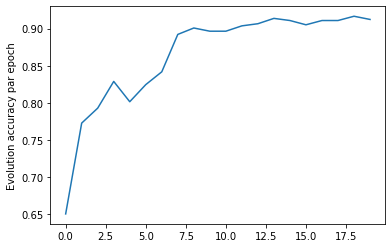

In [13]:
best_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

## Autre test sans paramétrage du réseaux par ImageNet

In [14]:
model_ft = models.resnet101(pretrained=False)

In [15]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
class_names = image_datasets['train'].classes
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 4.5390 Acc: 0.0422
val Loss: 7.4676 Acc: 0.0619

Epoch 1/24
----------
train Loss: 4.0352 Acc: 0.0489
val Loss: 5.4835 Acc: 0.0835

Epoch 2/24
----------
train Loss: 3.7823 Acc: 0.0725
val Loss: 5.6071 Acc: 0.0849

Epoch 3/24
----------
train Loss: 3.6471 Acc: 0.0763
val Loss: 6.5818 Acc: 0.1007

Epoch 4/24
----------
train Loss: 3.6463 Acc: 0.0835
val Loss: 5.7007 Acc: 0.1079

Epoch 5/24
----------
train Loss: 3.5075 Acc: 0.1051
val Loss: 4.9735 Acc: 0.1281

Epoch 6/24
----------
train Loss: 3.4924 Acc: 0.1065
val Loss: 8.1776 Acc: 0.1252

Epoch 7/24
----------
train Loss: 3.2554 Acc: 0.1416
val Loss: 6.3731 Acc: 0.1612

Epoch 8/24
----------
train Loss: 3.2703 Acc: 0.1372
val Loss: 4.4988 Acc: 0.1540

Epoch 9/24
----------
train Loss: 3.2362 Acc: 0.1531
val Loss: 5.2108 Acc: 0.1683

Epoch 10/24
----------
train Loss: 3.2204 Acc: 0.1430
val Loss: 7.2504 Acc: 0.1640

Epoch 11/24
----------
train Loss: 3.2098 Acc: 0.1497
val Loss: 5.2667 Acc: 0.1626

Ep

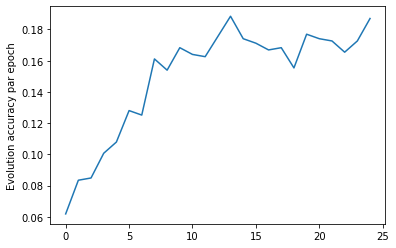

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

## Test en fixant le réseaux sauf pour la dernière couche  

In [17]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
class_names = image_datasets['train'].classes
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/14
----------
train Loss: 3.4627 Acc: 0.1468
val Loss: 3.2502 Acc: 0.4014

Epoch 1/14
----------
train Loss: 2.4643 Acc: 0.3906
val Loss: 3.2170 Acc: 0.5137

Epoch 2/14
----------
train Loss: 2.0091 Acc: 0.4866
val Loss: 3.4568 Acc: 0.6403

Epoch 3/14
----------
train Loss: 1.7644 Acc: 0.5461
val Loss: 2.0944 Acc: 0.6590

Epoch 4/14
----------
train Loss: 1.6002 Acc: 0.5753
val Loss: 2.3477 Acc: 0.6590

Epoch 5/14
----------
train Loss: 1.4760 Acc: 0.6224
val Loss: 3.8570 Acc: 0.6489

Epoch 6/14
----------
train Loss: 1.4008 Acc: 0.6296
val Loss: 2.6027 Acc: 0.7036

Epoch 7/14
----------
train Loss: 1.1808 Acc: 0.7035
val Loss: 1.4316 Acc: 0.7540

Epoch 8/14
----------
train Loss: 1.1899 Acc: 0.7198
val Loss: 1.5205 Acc: 0.7568

Epoch 9/14
----------
train Loss: 1.1562 Acc: 0.7212
val Loss: 2.9460 Acc: 0.7281

Epoch 10/14
----------
train Loss: 1.1727 Acc: 0.7164
val Loss: 3.2393 Acc: 0.7079

Epoch 11/14
----------
train Loss: 1.1751 Acc: 0.7150
val Loss: 3.6356 Acc: 0.7237

Ep

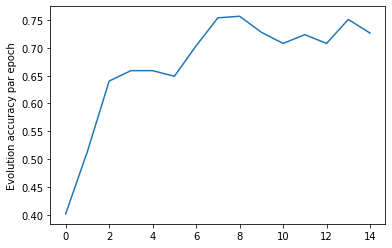

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

## Matrice de confusion du meilleur model

torch.Size([50, 50])


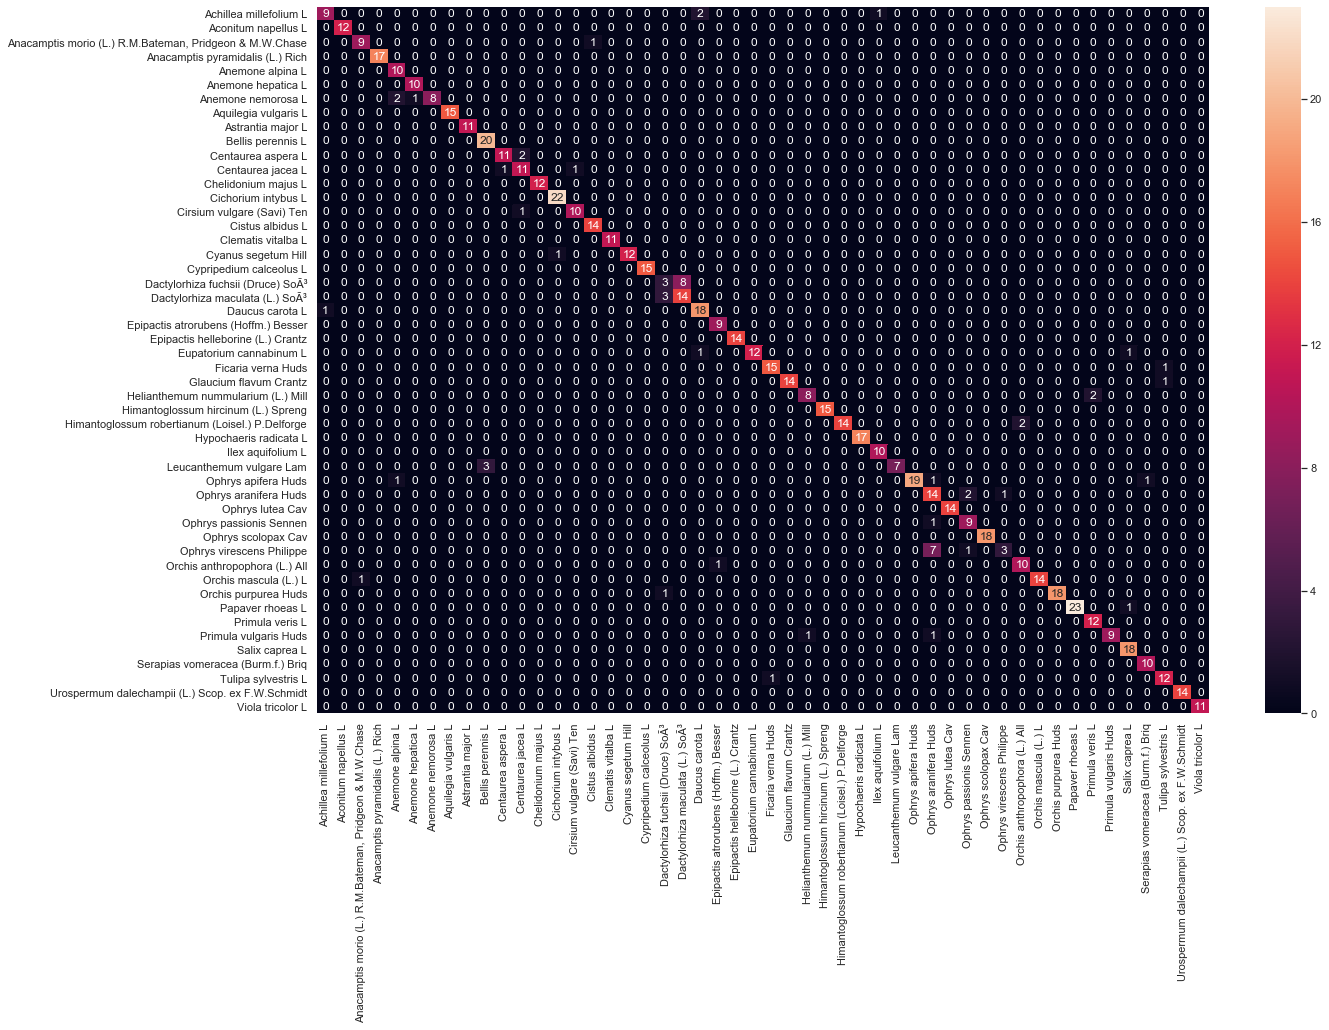

In [19]:
nb_classes = len(class_names)

normalize = False

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.shape)
# On affiche la matrice de confusion, normalisé ou non 
if normalize : 
    confusion_matrix = confusion_matrix.numpy()
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
plt.figure(figsize=(20, 13))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix, annot=True, xticklabels= class_names, yticklabels= class_names)

# correction du bug qui coupé le haut et le bas de la matrice de confusion
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()



On constate que deux espèces se confondent : Dactylorhiza maculata (L.) SoÃ³; Dactylorhiza fuchsii (Druce) SoÃ³.
On sait que ces deux espèces ont vraiment très peu de différence entre elles en regardant les photos et du fait qu'elles sont de la même famille (Orchidaceae) et même type (Dactylorhiza).
Il est donc difficile pour le réseaux de neuronne de faire la différence.

Pareil pour Ophrys passionis Sennen, Ophrys aranifera Huds et Ophrys virescens Philippe.
On peut se poser la question de pourquoi il n'arrive pas à classifier les Ophrys virescens Philippe et que pour les deux autres espèces, les erreurs sont beaucoup moins grande.

In [20]:
# On enregistre le modèle
PATH = './CNN/bestModel.pth'
torch.save(best_model, PATH)

C:\Users\Cedric\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Cedric\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Cedric\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Cedric\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\

## Test du model sur de nouvelle valeur

In [21]:
if(not os.path.isdir('./CNN/test')):
    os.mkdir('./CNN/test')
    

for classe in y_test : 
    if(not os.path.isdir('./CNN/test/'+classe)):
        os.mkdir('./CNN/test/'+classe)

directorys=os.listdir('./CNN/test/')
for i in range(0,len(directorys)):
    files=os.listdir('./CNN/test/'+directorys[i])
    for j in range(0,len(files)):
        os.remove('./CNN/test/'+directorys[i]+'/'+files[j])


for i in range(len(X_test)):
    shutil.copyfile('./train/'+X_test[i],'./CNN/test/'+y_test[i]+'/'+X_test[i])

In [22]:
PATH = 'CNN/bestModel.pth'
our_model = torch.load(PATH)
our_model.to(device)
optimizer = optim.SGD(our_model.parameters(), lr=0.001, momentum=0.9)

In [23]:
correct = 0
total = 0
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data = datasets.ImageFolder('./CNN/test/', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data)


Accuracy of the network on test images: 90 %


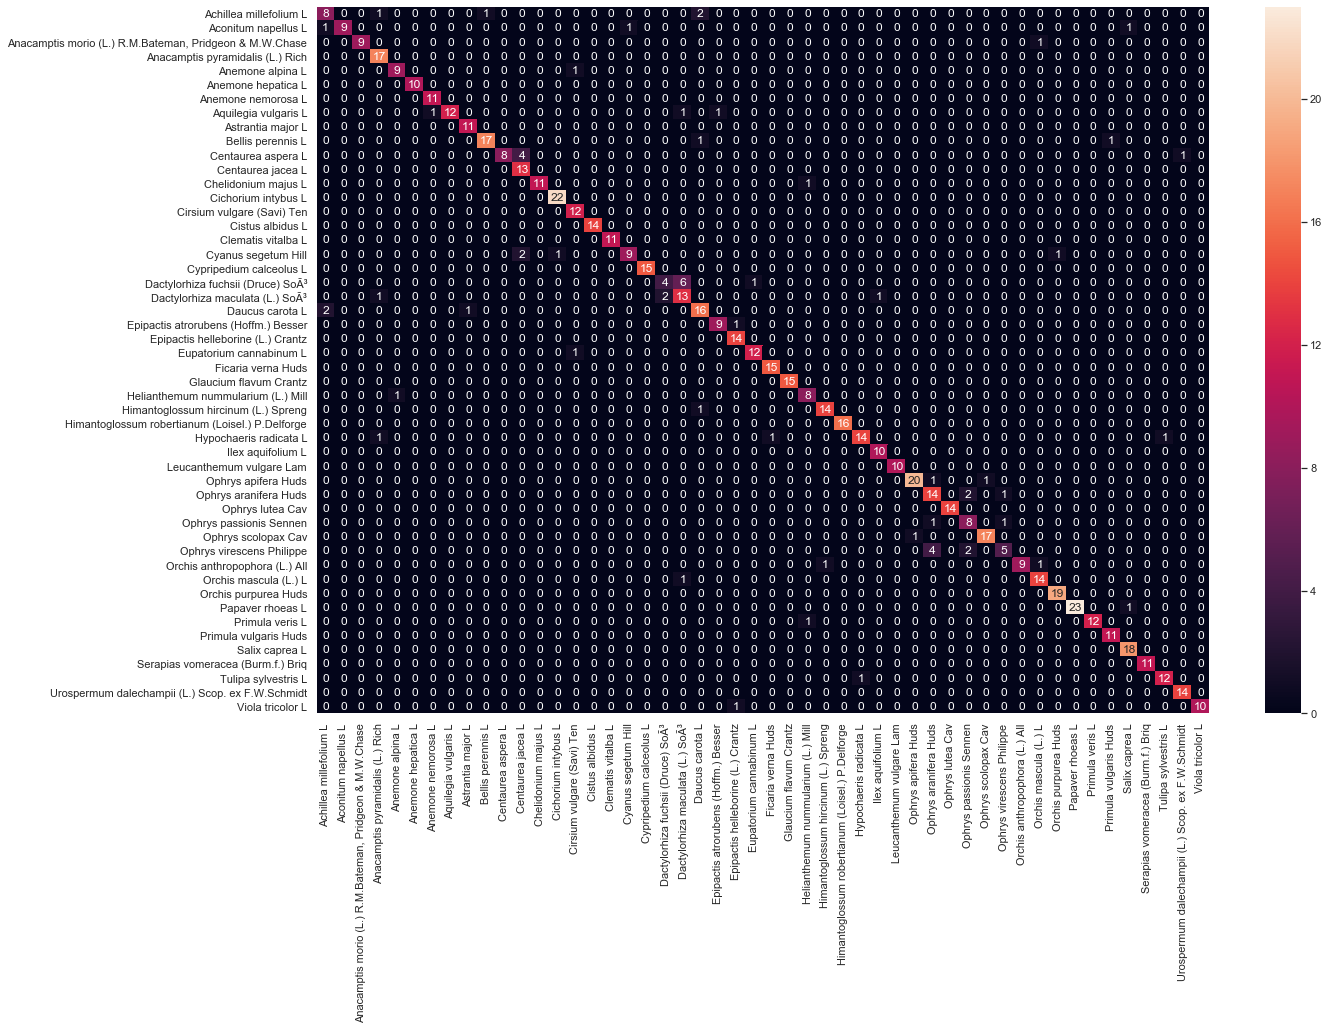

In [24]:
correct = 0
total = 0
nb_classes = len(test_data.classes)
class_names = test_data.classes
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        images = inputs.to(device)
        labels = classes.to(device)
        outputs = our_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1


print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

plt.figure(figsize=(20, 13))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix, annot=True, xticklabels= class_names, yticklabels= class_names)

# correction du bug qui coupé le haut et le bas de la matrice de confusion
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()
